In [19]:
# import basic libraries
import os
import numpy as np
import pandas as pd
import re
import random
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import pickle
import unicodedata
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import Counter
import plotly.io as pio
#import pyperclip
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
import json
import unicodedata
import duckdb
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import TruncatedSVD
from scipy import sparse
import numpy as np

from collections import Counter
from scipy.sparse import csr_matrix

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

from transformers import AutoTokenizer, AutoModel


import numpy as np
import pandas as pd
import importlib


In [32]:
# our own embedding functions
import helper_functions
importlib.reload(helper_functions)

<module 'helper_functions' from '/home/jupyter-vojta/notebooks/enemy-christianity/scripts/helper_functions.py'>

In [2]:
conn = duckdb.connect('/srv/data/greek/grela.duckdb', read_only=True)

In [3]:
enemy_annotations = pd.read_csv("../data/enemy-annotations - sentences.csv")
enemy_annotations.head(5)

,Unnamed: 0,sentence_id,grela_source,grela_id,author,title,not_before,not_after,lagt_tlg_epithet,lagt_genre,lagt_provenience,date_random,token_count,text,polemical category,notes
0,4,lagt_tlg4090.tlg001_8695,lagt,lagt_tlg4090.tlg001,Cyril of Alexandria,In XII Prophetas,412.0,444.0,['Theologici'],[],christian,425.0,482822,εἶτα δέον πάντας τούς ἐξ Ἰσραήλ ἐχθρούς ἡγεῖσθ...,1,"against Jews, δυσσεβείας"
1,5,lagt_tlg4090.tlg001_38952,lagt,lagt_tlg4090.tlg001,Cyril of Alexandria,In XII Prophetas,412.0,444.0,['Theologici'],[],christian,425.0,482822,μέθῃ δή οὖν καί σκότῳ καταληφθήσεσθαί φησι τού...,1,NaN
2,19,lagt_tlg4090.tlg001_60254,lagt,lagt_tlg4090.tlg001,Cyril of Alexandria,In XII Prophetas,412.0,444.0,['Theologici'],[],christian,425.0,482822,. . . . αὐτό . . αὐτῶ . τοαυτό . . πεφρασμένον...,1,NaN
3,29,lagt_tlg0317.tlg001_2231,lagt,lagt_tlg0317.tlg001,Acta Joannis,Acta Joannis,101.0,200.0,[],[],christian,180.0,23640,ὑμέρας ‖ μέρος ‖ ἤ ‖ ἐν παῤ αἰτῶ Δ ἀλλά πυρί α...,1,NaN
4,41,lagt_tlg2035.tlg131_764,lagt,lagt_tlg2035.tlg131,Athanasius,Oratio II contra Arianos,330.0,373.0,['Theologici'],[],christian,358.0,37973,ἕως ἄν . .( .) . θῶ τούς ἐχθρούς σου ὑποπόδιον...,1,NaN


In [4]:
# Python
enemy_annotations["polemical_category_first"] = (
    enemy_annotations["polemical category"]
    .apply(lambda x: x[0] if isinstance(x, str) and len(x) > 0 else None)
)

In [14]:
# add tokens data to annotated sentences
conn.register("enemy_annotations", enemy_annotations)

enemy_annotations = conn.execute("""
SELECT ea.*,
       COALESCE(st.tokens, []) AS tokens
FROM enemy_annotations ea
LEFT JOIN (
  SELECT
    t.sentence_id,
    LIST(
      STRUCT_PACK(
        token_id    := t.token_id,
        token_text  := t.token_text,
        lemma       := t.lemma,
        pos         := t.pos,
        char_start  := t.char_start,
        char_end    := t.char_end,
        sentence_id := t.sentence_id
      )
      ORDER BY t.token_id
    ) AS tokens
  FROM tokens t
  SEMI JOIN enemy_annotations ea USING (sentence_id)
  GROUP BY t.sentence_id
) st USING (sentence_id)
""").df()

In [15]:
def norm_tokens_lemmata(tokens, *, strip_diacritics: bool = True):
    out = []
    if tokens is None:
        return out

    # if tokens is numpy array, convert to list
    if isinstance(tokens, np.ndarray):
        tokens = tokens.tolist()

    for t in tokens:
        if not isinstance(t, dict):
            continue
        d = dict(t)  # avoid mutating the original
        if "lemma" in d and isinstance(d["lemma"], str):
            d["lemma"] = helper_functions.normalize_greek(d["lemma"], strip_diacritics=strip_diacritics)
        if "token" in d and isinstance(d["token"], str):
            d["token"] = helper_functions.normalize_greek(d["token"], strip_diacritics=strip_diacritics)
        out.append(d)
    return out

# apply the normalization
enemy_annotations["tokens"] = enemy_annotations["tokens"].apply(lambda toks: norm_tokens_lemmata(toks, strip_diacritics=False))
enemy_annotations.head(5)



,Unnamed: 0,sentence_id,grela_source,grela_id,author,title,not_before,not_after,lagt_tlg_epithet,lagt_genre,lagt_provenience,date_random,token_count,text,polemical category,notes,polemical_category_first,tokens,tokens_1,tokens_2
0,188,lagt_tlg2040.tlg004_4548,lagt,lagt_tlg2040.tlg004,"Basil, Saint, Bishop of Caesarea",Epistulae,330.0,378.0,['Theologici'],[],christian,371.0,159722,τῆς πάλαι μέν σπαρείσης αἱρέσεως ὑπό τοῦ ἐχθρο...,1,None,1,"[{'token_id': 153424793, 'token_text': 'τῆς', ...","[{'token_id': 153424793, 'token_text': 'τῆς', ...","[{'token_id': 153424793, 'token_text': 'τῆς', ..."
1,384,lagt_tlg4102.tlg001_1959,lagt,lagt_tlg4102.tlg001,Catenae (Novum Testamentum),Catena In Matthaeum,501.0,600.0,[],[],christian,581.0,94631,"ἀλλά μή ὡς πολέμιος, μή ὡς ἐχθρός ἀπαίτει δίκας,",5,None,5,"[{'token_id': 146315988, 'token_text': 'ἀλλά',...","[{'token_id': 146315988, 'token_text': 'ἀλλά',...","[{'token_id': 146315988, 'token_text': 'ἀλλά',..."
2,138,lagt_tlg4102.tlgX03_1858,lagt,lagt_tlg4102.tlgX03,Catenae (Novum Testamentum),Commentarius In Apocalypsin,501.0,600.0,[],[],christian,581.0,27419,", ἐχθρούς τῆς ἀληθείας καί τῆς δικαιοσύνης ἐκπ...",2,None,2,"[{'token_id': 155948513, 'token_text': ',', 'l...","[{'token_id': 155948513, 'token_text': ',', 'l...","[{'token_id': 155948513, 'token_text': ',', 'l..."
3,855,lagt_tlg0525.tlg001_11479,lagt,lagt_tlg0525.tlg001,Pausanias,Ἑλλάδος Περιηγήσεως,150.0,180.0,['Periegetae'],[],pagan,150.0,244486,δυνάστην ἄνδρα ἐπιβουλὴν ἐχθρῶν ὑποπτεύσαντα ἐ...,None,None,None,"[{'token_id': 170142867, 'token_text': 'δυνάστ...","[{'token_id': 170142867, 'token_text': 'δυνάστ...","[{'token_id': 170142867, 'token_text': 'δυνάστ..."
4,628,lagt_tlg0658.tlg001_271,lagt,lagt_tlg0658.tlg001,Heliodorus of Emesa,Aethiopica,220.0,230.0,['Scriptores Erotici'],[],pagan,226.0,90138,"ὃ δὲ εἵπετο, καὶ ἐπιστὰς εἰστρέχει τε εἰς τὸ δ...",1,None,1,"[{'token_id': 168821247, 'token_text': 'ὃ', 'l...","[{'token_id': 168821247, 'token_text': 'ὃ', 'l...","[{'token_id': 168821247, 'token_text': 'ὃ', 'l..."


In [17]:
enemy_annotations.to_parquet("../data/enemy-annotations_tokens.parquet")

In [16]:
with open ("/srv/data/enemy-christ/large-data/grouped_df.pkl", "rb") as f:
    grouped = pickle.load(f)

/tmp/ipykernel_2911330/57775235.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  grouped = pickle.load(f)


In [9]:
grouped["tokens"][0]

[{'lemma': 'πινυτός',
  'token': 'Πινυτὸς',
  'pos': 'NOUN',
  'char_start': 12,
  'char_end': 19},
 {'lemma': 'ἀντίγραφον',
  'token': 'ἀντιγράφων',
  'pos': 'VERB',
  'char_start': 20,
  'char_end': 30},
 {'lemma': 'θαυμάζω',
  'token': 'θαυμάζει',
  'pos': 'VERB',
  'char_start': 32,
  'char_end': 40},
 {'lemma': 'ἀποδέχομαι',
  'token': 'ἀποδέχεται',
  'pos': 'VERB',
  'char_start': 49,
  'char_end': 59},
 {'lemma': 'διονύσιος',
  'token': 'Διονύσιον',
  'pos': 'NOUN',
  'char_start': 64,
  'char_end': 73}]

In [18]:
grouped["sentence_text"][0]

' πρὸς ἣν, ὁ Πινυτὸς ἀντιγράφων, θαυμάζει μὲν καὶ ἀποδέχεται τὸν Διονύσιον·'

In [20]:
tokenizer_agbert = AutoTokenizer.from_pretrained("pranaydeeps/Ancient-Greek-BERT")
model_agbert = AutoModel.from_pretrained("pranaydeeps/Ancient-Greek-BERT")

/srv/venvs/greek_venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [26]:
tokenizer_xlmr = AutoTokenizer.from_pretrained("xlm-roberta-base")
model_xlmr = AutoModel.from_pretrained("xlm-roberta-base")

/srv/venvs/greek_venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

In [22]:
# 3) LaBSE
tokenizer_labse = AutoTokenizer.from_pretrained("sentence-transformers/LaBSE")
model_labse = AutoModel.from_pretrained("sentence-transformers/LaBSE")

pytorch_model.bin:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

In [23]:
tokenizer_agbuncased = AutoTokenizer.from_pretrained("pranaydeeps/Ancient-Greek-BERT", use_fast=False)
model_agbuncased    = AutoModel.from_pretrained("altsoph/bert-base-ancientgreek-uncased")

/srv/venvs/greek_venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [24]:
device = "cpu" # "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
sent = helper_functions.normalize_greek(enemy_annotations["text"][0])
sent

'της παλαι μεν σπαρεισης αιρεσεως υπο του εχθρου της αληθειας Αρειου, νυν δε προς το αναισχυντον αναφανεισης και οιονει ριζης πικρας καρπον ολεθριον αναδιδουσης, κατακρατουσης λοιπον δια το τους μεν καθ εκαστην παροικιαν προεστωτας του ορθου λογου εκ συκοφαντιας και επηρειας των εκκλησιων εκπεσειν, παραδοθηναι δε τοις αιχμαλωτιζουσι τας ψυχας των ακεραιοτερων την των πραγματων ισχυν.'

In [13]:
input_ids = tokenizer_agbert.encode(sent)
tokens = tokenizer_agbert.convert_ids_to_tokens(input_ids)
print(tokens)

['[CLS]', 'ει', '##τα', 'δε', '##ον', 'παντα', '##ς', 'τους', 'εξ', 'ισραηλ', 'εχθρους', 'η', '##γει', '##σθαι', 'και', 'πολεμι', '##ωτατο', '##υς', 'τους', 'απο', 'δαν', ',', 'και', 'της', 'εις', 'θεον', 'δυσ', '##σε', '##βει', '##ας', 'εξα', '##ιτη', '##σαι', 'λογους', ',', 'ταχα', 'που', 'και', 'συνη', '##νε', '##χθη', '##σαν', ',', '[SEP]']


In [27]:
# Compute embeddings
emb_matrix = helper_functions.bert_sentence_embeddings(
    list(enemy_annotations["text"].apply(helper_functions.normalize_greek)),
    tokenizer=tokenizer_agbert,
    model=model_agbert,
    device=device,
    batch_size=32,           # adjust for your GPU/CPU RAM
    max_length=tokenizer_agbert.model_max_length,
    l2_normalize=True,       # set False if you prefer raw vectors
)

enemy_annotations["sent_emb_agbert"] = [emb for emb in emb_matrix]

In [28]:
# Compute embeddings
emb_matrix = helper_functions.bert_sentence_embeddings(
    list(enemy_annotations["text"].apply(helper_functions.normalize_greek)),
    tokenizer=tokenizer_xlmr,
    model=model_xlmr,
    device=device,
    batch_size=32,           # adjust for your GPU/CPU RAM
    max_length=tokenizer_xlmr.model_max_length,
    l2_normalize=True,       # set False if you prefer raw vectors
)

enemy_annotations["sent_emb_xlmr"] = [emb for emb in emb_matrix]

In [29]:
emb_matrix = helper_functions.bert_sentence_embeddings(
    list(enemy_annotations["text"].apply(helper_functions.normalize_greek)),
    tokenizer=tokenizer_labse,
    model=model_labse,
    device=device,
    batch_size=32,
    max_length=tokenizer_labse.model_max_length,
    l2_normalize=True,
)

enemy_annotations["sent_emb_labse"] = [emb for emb in emb_matrix]

## Obtain target token embedding too

In [30]:
# 1) Build a Series of 3-tuples (sent_str, sp_tokens, aug_tokens)
out = enemy_annotations["tokens"].apply(
    lambda toks: helper_functions.augment_with_subwords(
        toks,
        tokenizer=tokenizer_agbert,
        anchor_use_lemma=True,
        target_lemma="ἐχθρός",
    )
)

# 2) Unzip into three new columns
enemy_annotations["sent_str"], enemy_annotations["sp_tokens"], enemy_annotations["aug_tokens"] = zip(*out)

In [33]:
# compute vectors row-wise
enemy_annotations["enemy_emb"] = enemy_annotations.apply(
    lambda row: helper_functions.hidden_anchor_embedding(
        row["aug_tokens"],
        row["sent_str"],
        tokenizer=tokenizer_agbert,
        model=model_agbert,
        device="cpu",       # "cpu" or "cuda"
        target_lemma="ἐχθρός",
        piece_pooling="mean",
    ),
    axis=1
)

In [34]:
enemy_annotations.to_parquet("../data/enemy_annotations_emb.parquet")

## 2D plotting

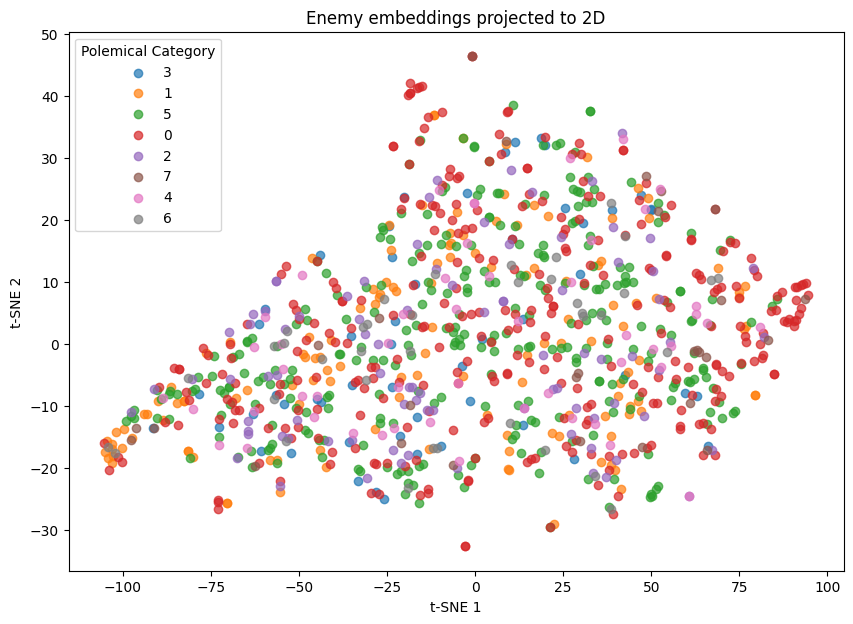

In [49]:
# 1) Stack your embeddings into a 2D array
X = np.stack(enemy_annotations["sent_emb_xlmr"].to_numpy())  # shape (n, hidden_size)

# 2) Dimensionality reduction (to 2D)
tsne = TSNE(n_components=2, random_state=42, init="random", learning_rate="auto", perplexity=10)
X_2d = tsne.fit_transform(X)

# 3) Add to your DataFrame for convenience
enemy_annotations["x"] = X_2d[:,0]
enemy_annotations["y"] = X_2d[:,1]

# 4) Scatter plot, coloring by "polemical category"
plt.figure(figsize=(10,7))
categories = enemy_annotations["polemical_category_first"].unique()

for cat in categories:
    subset = enemy_annotations[enemy_annotations["polemical_category_first"] == cat]
    plt.scatter(subset["x"], subset["y"], label=cat, alpha=0.7)

plt.legend(title="Polemical Category")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("Enemy embeddings projected to 2D")
plt.show()

## Classification

In [37]:
EMB_COL = "sent_emb_agbert"
LABEL_COL = "polemical_category_first"
# 1) Drop rows where embeddings are missing or empty
enemy_annotations = enemy_annotations[
    enemy_annotations[EMB_COL].apply(lambda v: isinstance(v, np.ndarray) and v.size > 0)
].reset_index(drop=True)

# 2) Replace missing categories with "0"
enemy_annotations[LABEL_COL] = enemy_annotations[LABEL_COL].fillna("0").astype(str)

In [38]:
# common objects
# ------------------------------------------------------------------
y = enemy_annotations["polemical_category_first"].values  # 21 classes incl. “other”
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# basic experiments with contextual embeddings

lr = LogisticRegression(
    max_iter=4000,
    solver="lbfgs",
    n_jobs=-1)

mlp = MLPClassifier(hidden_layer_sizes=(512, 128),
                    activation='relu',
                    solver='adam',
                    alpha=1e-4,
                    max_iter=500,
                    random_state=42)

clfs = {"lr" : lr, "mlp" : mlp}

In [47]:
emb_col = "enemy_emb"
X = np.stack(enemy_annotations[emb_col].values)

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Embedding columns to evaluate
emb_cols = [
    "enemy_emb",        # target word embeddings (AGBERT)
    "sent_emb_agbert",  # sentence embeddings (AGBERT)
    "sent_emb_xlmr",    # sentence embeddings (XLM-R)
    "sent_emb_labse",   # sentence embeddings (LaBSE)
]

# Results
results = []
conf_mats = {}

for emb_col in emb_cols:
    X = np.stack(enemy_annotations[emb_col].values)
    for clf_name, clf in clfs.items():
        y_pred = cross_val_predict(clf, X, y, cv=cv)
        acc = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average="macro")

        results.append({
            "embedding": emb_col,
            "classifier": clf_name,
            "accuracy": acc,
            "F1 (macro)": f1
        })

        # Save confusion matrix
        cm = confusion_matrix(y, y_pred, labels=np.unique(y))
        conf_mats[(emb_col, clf_name)] = cm

# Pretty results table
results_df = pd.DataFrame(results)
print(results_df)

In [51]:
results_df

,embedding,classifier,accuracy,F1 (macro)
0,enemy_emb,lr,0.398,0.232585
1,enemy_emb,mlp,0.400,0.230703
2,sent_emb_agbert,lr,0.457,0.163110
3,sent_emb_agbert,mlp,0.442,0.312287
4,sent_emb_xlmr,lr,0.368,0.114052
5,sent_emb_xlmr,mlp,0.381,0.239926
6,sent_emb_labse,lr,0.456,0.181912
7,sent_emb_labse,mlp,0.386,0.267734


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

         embedding classifier  accuracy  F1 (macro)
0        enemy_emb         lr     0.398    0.232585
1        enemy_emb        mlp     0.400    0.230703
2  sent_emb_agbert         lr     0.457    0.163110
3  sent_emb_agbert        mlp     0.442    0.312287
4    sent_emb_xlmr         lr     0.368    0.114052
5    sent_emb_xlmr        mlp     0.381    0.239926
6   sent_emb_labse         lr     0.456    0.181912
7   sent_emb_labse        mlp     0.386    0.267734


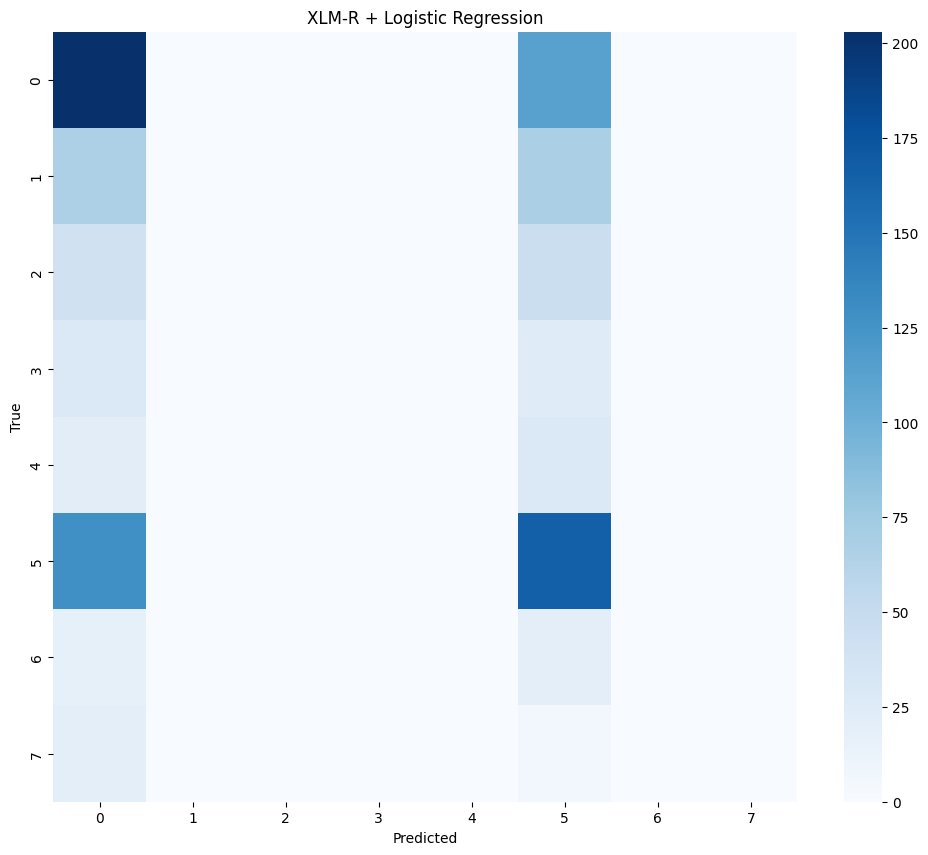

In [50]:

# Example: show confusion matrix for one setup
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cm(cm, labels, title):
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# Example usage: plot for XLM-R + Logistic Regression
labels = np.unique(y)
plot_cm(conf_mats[("sent_emb_xlmr", "lr")], labels, "XLM-R + Logistic Regression")